In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers


In [28]:
inputs1 = np.load(r"data\inputs_segment0.npy")
targets1 = np.load(r"data\targets_segment0.npy")

inputs2 = np.load(r"data\inputs_segment1.npy")
targets2 = np.load(r"data\targets_segment1.npy")

inputs3 = np.load(r"data\inputs_segment3.npy")
targets3 = np.load(r"data\targets_segment3.npy")

inputs4 = np.load(r"data\inputs_segment4.npy")
targets4 = np.load(r"data\targets_segment4.npy")

print(inputs1.shape)

(71, 15, 15)


In [29]:
inputs0 = np.concatenate((inputs1, inputs2, inputs3, inputs4), axis=0)
print(inputs0.shape)

targets0 = np.concatenate((targets1, targets2, targets3, targets4), axis=0)


kolowosc0 = targets0[:, [1]].astype("float32")
promien = targets0[:,[0]].astype('float32')

print(promien.shape)

(429, 15, 15)
(429, 1)


(np.float64(-0.5), np.float64(14.5), np.float64(14.5), np.float64(-0.5))

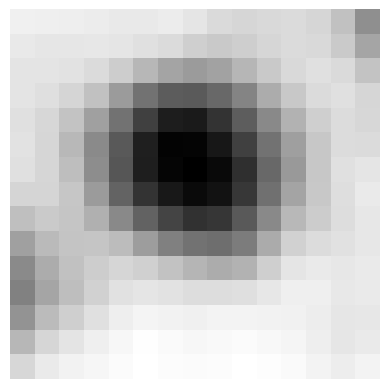

In [30]:
plt.imshow(inputs0[20], cmap="Greys")
plt.axis('off')

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    inputs0, promien,
    test_size=0.2,
    random_state=42
)

In [33]:
# Trenowanie CNN z 3 warstwami konwolucyjnymi
model = models.Sequential([
    layers.Input(shape=(15, 15, 1)),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])

In [34]:
loss = tf.keras.losses.MeanAbsoluteError()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
    loss=loss,
    metrics=['mae', 'mse']
)

In [35]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=320,
    batch_size=2,
)

Epoch 1/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6354 - mae: 0.6354 - mse: 0.6348 - val_loss: 0.3966 - val_mae: 0.3966 - val_mse: 0.2160
Epoch 2/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3467 - mae: 0.3467 - mse: 0.1931 - val_loss: 0.3540 - val_mae: 0.3540 - val_mse: 0.1786
Epoch 3/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3337 - mae: 0.3337 - mse: 0.1848 - val_loss: 0.3515 - val_mae: 0.3515 - val_mse: 0.1731
Epoch 4/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3151 - mae: 0.3151 - mse: 0.1601 - val_loss: 0.3164 - val_mae: 0.3164 - val_mse: 0.1478
Epoch 5/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3039 - mae: 0.3039 - mse: 0.1617 - val_loss: 0.2936 - val_mae: 0.2936 - val_mse: 0.1306
Epoch 6/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2892 - mae: 0.2892 - mse: 0.1414 - val_loss: 0.3188 - val_mae: 0.3188 - val_mse: 0.1443
Epoch 7/320
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2554 - mae: 0.2554 - mse: 0.114

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


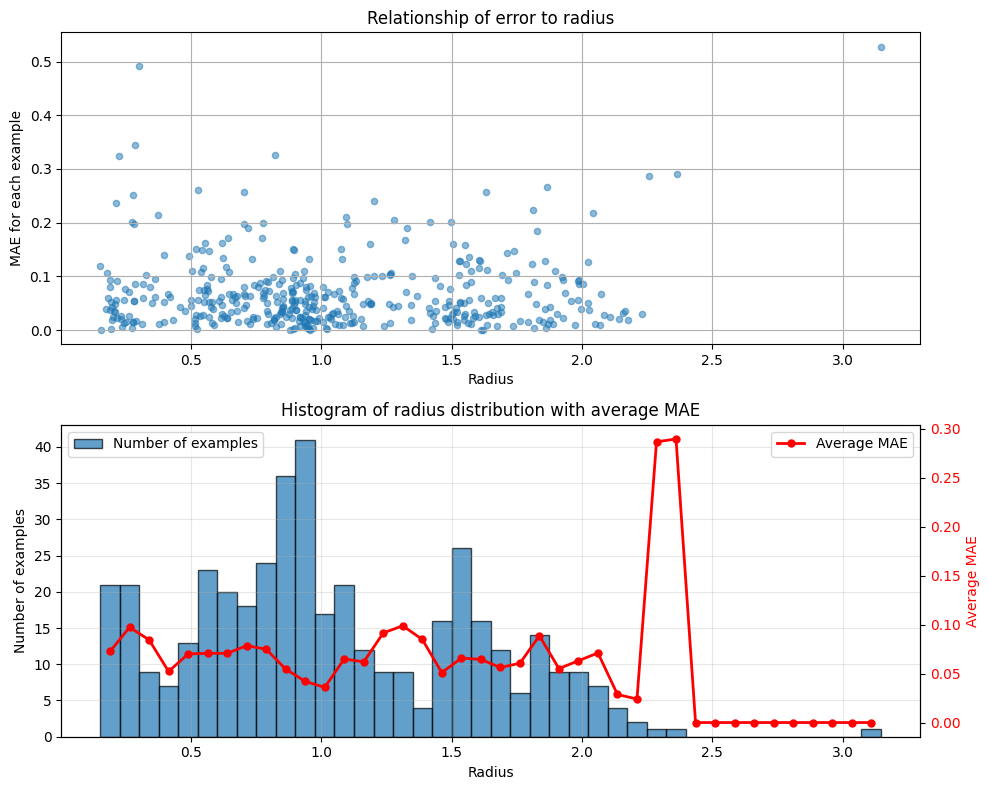

In [36]:
# Predykcja modelu na zbiorze walidacyjnym
y_pred_val = model.predict(X_val)

# Obliczenie błędu dla każdego przykładu (wartość bezwzględna różnicy)
mae_per_sample_val = np.abs(y_pred_val - y_val).flatten()

# Ponieważ train_test_split nie zwraca indeksów, użyjemy całego zbioru
# i zrobimy predykcję na wszystkich danych
y_pred_all = model.predict(inputs0)
mae_per_sample_all = np.abs(y_pred_all - promien).flatten()
promien_all = promien.flatten()

# Wykresy zależności błędu od promienia
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Lewy subplot - scatter plot
axes[0].scatter(promien_all, mae_per_sample_all, alpha=0.5, s=20)
axes[0].set_xlabel('Radius')
axes[0].set_ylabel('MAE for each example')
axes[0].set_title('Relationship of error to radius')
axes[0].grid(True)

# Prawy subplot - histogram z linią
n, bins, patches = axes[1].hist(promien_all, bins=40, edgecolor='black', alpha=0.7, label='Number of examples')

# Obliczenie średniego MAE dla każdego bina
bin_centers = (bins[:-1] + bins[1:]) / 2
mae_means = []
for i in range(len(bins)-1):
    mask = (promien_all >= bins[i]) & (promien_all < bins[i+1])
    if mask.sum() > 0:
        mae_means.append(mae_per_sample_all[mask].mean())
    else:
        mae_means.append(0)

# Oś wtórna dla MAE
ax2 = axes[1].twinx()

# MAE line on secondary Y axis
ax2.plot(bin_centers, mae_means, 'r-o', linewidth=2, markersize=5, label='Average MAE')
ax2.set_ylabel('Average MAE', color='r')
ax2.tick_params(axis='y', labelcolor='r')

axes[1].set_xlabel('Radius')
axes[1].set_ylabel('Number of examples')
axes[1].set_title('Histogram of radius distribution with average MAE')
axes[1].grid(True, alpha=0.3)

# Legendy
axes[1].legend(loc='upper left')
ax2.legend(loc='upper right')


plt.tight_layout()
plt.show()

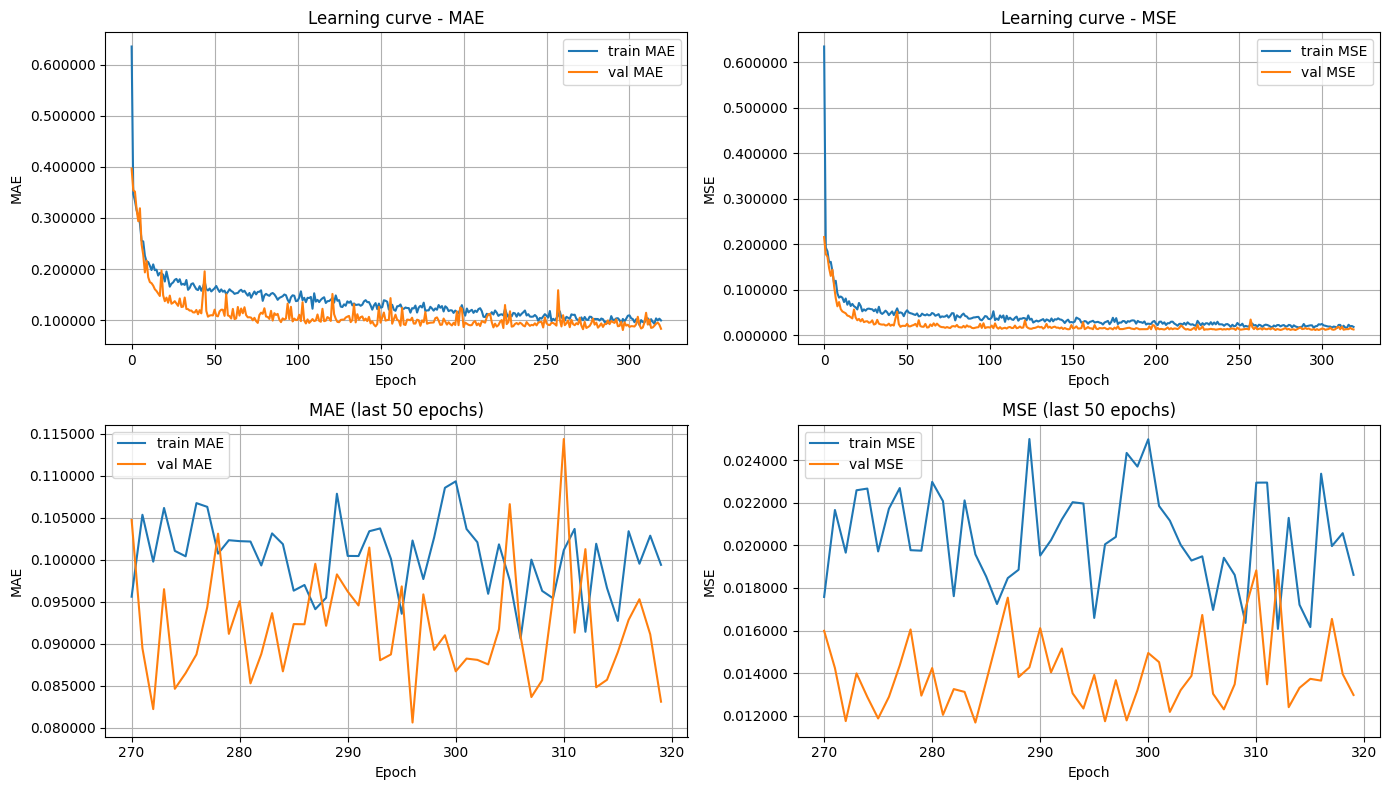

In [37]:
import matplotlib.pyplot as plt


# Wizualizacja krzywych trenowania
plt.figure(figsize=(14,8))

# Górny rząd - wszystkie epoki
plt.subplot(2,2,1)
plt.plot(history.history['mae'], label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.title('Learning curve - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(history.history['mse'], label='train MSE')
plt.plot(history.history['val_mse'], label='val MSE')
plt.title('Learning curve - MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

# Dolny rząd - ostatnie 50 epok
plt.subplot(2,2,3)
epochs_range = range(len(history.history['mae']) - 50, len(history.history['mae']))
plt.plot(epochs_range, history.history['mae'][-50:], label='train MAE')
plt.plot(epochs_range, history.history['val_mae'][-50:], label='val MAE')
plt.title('MAE (last 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('MAE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
epochs_range = range(len(history.history['mse']) - 50, len(history.history['mse']))
plt.plot(epochs_range, history.history['mse'][-50:], label='train MSE')
plt.plot(epochs_range, history.history['val_mse'][-50:], label='val MSE')
plt.title('MSE (last 50 epochs)')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.6f}'))

plt.legend()
plt.grid(True)

plt.tight_layout()




In [38]:
# Podsumowanie wyników treningowych
print("=" * 60)
print("TRAINING RESULTS SUMMARY")
print("=" * 60)

# Accuracy (based on MAE and data range)
target_range = promien.max() - promien.min()
accuracy_train = (1 - (history.history['mae'][-1] / target_range)) * 100
accuracy_val = (1 - (history.history['val_mae'][-1] / target_range)) * 100

print("\n EVALUATION (based on MAE):")
print(f"  Train: {accuracy_train:.2f}%")
print(f"  Val:   {accuracy_val:.2f}%")

# Overfitting/Underfitting
val_train_diff = history.history['val_loss'][-1] - history.history['loss'][-1]
print("\n  GENERALIZATION:")
if val_train_diff > 0.001:
    print(f"  Trend: OVERFITTING (Val loss > Train loss, difference: {val_train_diff:.6f})")
elif val_train_diff < -0.001:
    print(f"  Trend: UNDERFITTING (Val loss < Train loss, difference: {val_train_diff:.6f})")
else:
    print(f"  Trend: BALANCED (Val loss ≈ Train loss, difference: {val_train_diff:.6f})")


# Number of epochs
print(f"\n  NUMBER OF EPOCHS: {len(history.history['loss'])}")

# MAE
print(f"\n MAE for validation set: {history.history['val_mae'][-1]}")

print("=" * 60)

TRAINING RESULTS SUMMARY

 EVALUATION (based on MAE):
  Train: 96.68%
  Val:   97.22%

  GENERALIZATION:
  Trend: UNDERFITTING (Val loss < Train loss, difference: -0.016301)

  NUMBER OF EPOCHS: 320

 MAE for validation set: 0.08307753503322601


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.02781467


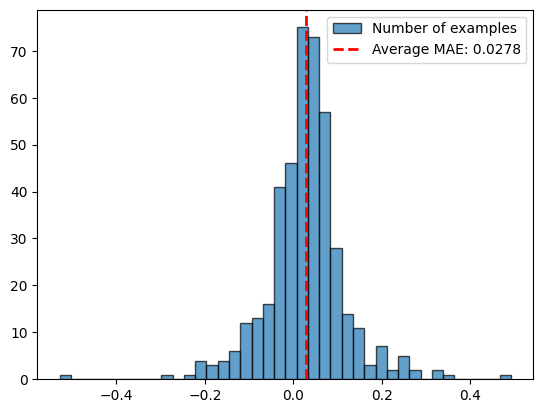

In [39]:

y_pred_all = model.predict(inputs0)
blad_kolowosc = (y_pred_all - promien).flatten()

# Histogram
plt.hist(blad_kolowosc, bins=40, edgecolor='black', alpha=0.7, label='Number of examples')

# Average MAE line
srednia_mae = np.mean(blad_kolowosc)
plt.axvline(srednia_mae, color='red', linestyle='--', linewidth=2, label=f'Average MAE: {srednia_mae:.4f}')
plt.legend()

print(np.mean(blad_kolowosc))